# Introduction
This project explores apprenticeship contract cancellations in Australia using NCVER data. The aim is to:
1. Identify key drivers behind cancellations through EDA
2. Build a ML model to predict the likelihood of cancellation based on the available apprentice features


# 1. Prepare and clean data

In [1]:
import pandas as pd

In [2]:
#import tables
df_cancel = pd.read_excel("/Users/joelche/Documents/Projects/Apprenticeships/Apprentice_trainee.xlsx",sheet_name='cancel', header=None)
df_commence = pd.read_excel("/Users/joelche/Documents/Projects/Apprenticeships/Apprentice_trainee.xlsx",sheet_name='commence', header=None)
df_complete = pd.read_excel("/Users/joelche/Documents/Projects/Apprenticeships/Apprentice_trainee.xlsx",sheet_name='complete', header=None)

In [3]:
#function to clean and reshape apprentinceship datasets 

def clean_data(df_raw, status_type):

    #map 'type' to cancel flag
    cancel_flag = 1 if status_type == 'cancel' else 0

    #extract first 5 rows and transpose to get header columns
    multi_col_tuples = list(zip(
        df_raw.iloc[0,3:], #industry
        df_raw.iloc[1,3:], #occupation
        df_raw.iloc[2,3:], #gender
        df_raw.iloc[3,3:], #year
        df_raw.iloc[4,3:], #quarter
    ))

    #extract values
    #drop second column
    df_values = df_raw.drop(df_raw.columns[[0,2]],axis=1).reset_index(drop=True)
    #extract values for each state
    state_tuples = list(zip(
        df_values.iloc[5,1:], #totals
        df_values.iloc[6,1:], #NSW
        df_values.iloc[7,1:], #VIC
        df_values.iloc[8,1:], #QLD
        df_values.iloc[9,1:], #SA
        df_values.iloc[10,1:], #WA
        df_values.iloc[11,1:], #TAS
        df_values.iloc[12,1:], #NT
        df_values.iloc[13,1:], #ACT
    ))


    df_dim = pd.DataFrame(multi_col_tuples, columns=['industry','occupation','gender','year','quarter'])
    df_state = pd.DataFrame(state_tuples, columns=['totals','NSW','VIC','QLD','SA','WA','TAS','NT','ACT'])

    #concatenate dataframes
    df_raw = pd.concat([df_dim,df_state],axis=1)


    #add binary cancellation column where 1=cancelled and 0=not cancelled
    df_raw['cancel'] = cancel_flag

    #replace "-" with 0
    df_raw = df_raw.replace('-',0)

    #add 
    df_raw['type'] = status_type
    
    return df_raw

In [4]:
#apply function to raw data frames
df1_cancel = clean_data(df_cancel, 'cancel')
df1_commence = clean_data(df_commence, 'commence')
df1_complete = clean_data(df_complete, 'complete')

In [5]:
#merge common fields
df_all = pd.concat([df1_cancel, df1_commence,df1_complete], ignore_index=True)

In [6]:
#remove totals column
df_all = df_all.drop('totals',axis=1)

In [7]:
#melt state columns into long format
df1_all = df_all.melt(
    id_vars=['occupation','gender','year','quarter','cancel','type'],
    value_vars=['NSW','VIC','QLD','SA','WA','TAS','NT','ACT'],
    var_name='state',
    value_name='count'
)

In [8]:
#since we are removing the industry column we have to group and aggregate values
df2_all = df1_all.groupby(['occupation','gender','year','quarter','state','cancel','type'], as_index=False)['count'].sum()

In [9]:
#remove all rows where count==0 
df2_all = df2_all[df2_all['count'] > 0]


In [10]:
df2_all.head(10)

,occupation,gender,year,quarter,state,cancel,type,count
0,1112 - General Managers,Females,2019,Apr-Jun,ACT,0,complete,5
5,1112 - General Managers,Females,2019,Apr-Jun,TAS,0,complete,5
7,1112 - General Managers,Females,2019,Apr-Jun,WA,0,complete,5
8,1112 - General Managers,Females,2019,Jul-Sep,ACT,0,complete,10
14,1112 - General Managers,Females,2019,Jul-Sep,VIC,0,complete,5
26,1112 - General Managers,Females,2019,Oct-Dec,TAS,0,commence,10
44,1112 - General Managers,Females,2020,Apr-Jun,SA,0,commence,5
54,1112 - General Managers,Females,2020,Apr-Jun,WA,0,complete,5
64,1112 - General Managers,Females,2020,Jul-Sep,ACT,0,complete,10
65,1112 - General Managers,Females,2020,Jul-Sep,ACT,1,cancel,5


In [11]:
#check for duplicate values
dupes = df2_all.duplicated(subset=['occupation', 'gender', 'year', 'quarter', 'state', 'cancel'])
print("Remaining duplicates:", dupes.sum())

Remaining duplicates: 4879


In [12]:
df2_all.shape

(28584, 8)

In [13]:
df2_all.nunique()

occupation    212
gender          3
year            6
quarter         4
state           8
cancel          2
type            3
count         198
dtype: int64

In [14]:
#remove unknown gender
df2_all = df2_all[df2_all['gender'].isin(['Males','Females'])]

In [15]:
df2_all['gender'].unique()

array(['Females', 'Males'], dtype=object)

# 2. Exploratory Data Analysis

In the exploratory data analysis, I will analyse each feature individually and make an assessment on the impact it has on the cancellation rate of apprenticeship programs

The cancellation rate can be defined as the percentage of apprentices who cancelled their training contracts out of all apprentices who are no longer in training (i.e. either cancelled or compmleted)

## 2.1 Gender analysis

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
#cancellation rate for each gender
df_end = df2_all[df2_all['type'].isin(['cancel','complete'])]

#group and sum counts by gender and type
gender_summary = df_end.groupby(['gender','type'])['count'].sum().unstack(fill_value=0)

#calculate cancellation rate
gender_summary['cancel_rate'] = gender_summary['cancel']/(gender_summary['cancel'] + gender_summary['complete'])

gender_summary

type,cancel,complete,cancel_rate
gender,,,
Females,75255,78235,0.490293
Males,249080,209155,0.543564


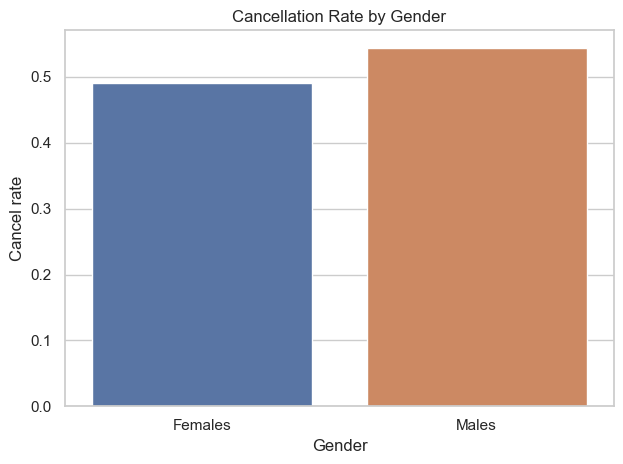

In [18]:
#plot results
sns.set(style='whitegrid')
ax = sns.barplot(x=gender_summary.index, y=gender_summary['cancel_rate'])

#add labels
ax.set_title('Cancellation Rate by Gender')
ax.set_ylabel('Cancel rate')
ax.set_xlabel('Gender')

plt.tight_layout()
plt.show()



Key insights:

1. Males(54%) have slightly higher cancellation rate than females(49%) suggesting males are  more likely to not complete their apprenticeships than females

2. Both genders have high cancellation rates. This could indicate structural issues with support, expectations, job alignment etc.

3. There are far more males than females participating in apprenticeship programs. This reflects that males still make up the marjority of trade employment


## 2.2 Occupation analysis

In [19]:

#group and sum counts by occupation and type
occ_summary = df_end.groupby(['occupation','type'])['count'].sum().unstack(fill_value=0)

#calculate cancellation rate
occ_summary['cancel_rate'] = occ_summary['cancel']/(occ_summary['cancel'] + occ_summary['complete'])

#absolute count
occ_summary['abs_count'] = occ_summary['cancel']+occ_summary['complete']

#sort by highest cancellation rate
occ_summary = occ_summary.sort_values(by='cancel_rate',ascending=False)

#exclude low-volume occupations
occ_summary = occ_summary[(occ_summary['cancel']+occ_summary['complete'])>1000]

occ_summary.head(20)

type,cancel,complete,cancel_rate,abs_count
occupation,,,,
2721 - Counsellors,1725,440,0.796767,2165
5911 - Purchasing and Supply Logistics Clerks,7645,2935,0.722590,10580
4314 - Hotel Service Managers,2150,880,0.709571,3030
3126 - Safety Inspectors,1015,455,0.690476,1470
"3121 - Architectural, Building and Surveying Technicians",1750,800,0.686275,2550
3511 - Bakers and Pastrycooks,2810,1405,0.666667,4215
3333 - Roof Tilers,985,495,0.665541,1480
3514 - Cooks,12420,6265,0.664704,18685
3321 - Floor Finishers,695,355,0.661905,1050


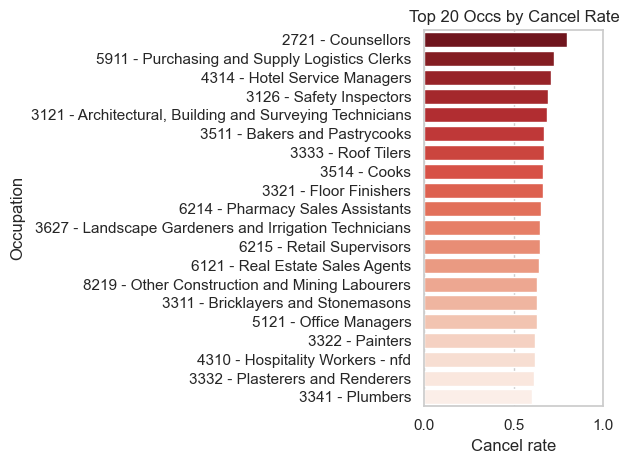

In [20]:
#plot results

top_occ = occ_summary[occ_summary['cancel_rate']>0.5].head(20)

ax = sns.barplot(data=top_occ.reset_index(),y='occupation',x='cancel_rate',palette='Reds_r')

#add labels
ax.set_title('Top 20 Occs by Cancel Rate')
ax.set_ylabel('Occupation')
ax.set_xlabel('Cancel rate')

plt.xlim(0,1)
plt.tight_layout()
plt.show()

Key insights:

1. Hospitality and retail are overrepresented. Cooks, retail supervisors, pharmacy sales assistant all appear in the top 20. This can be due to the industry having high staff turnover, involve shift work, high labour and low pay.

2. Construction trades such as roof tilers and painters also appear heavily. Possibly driven by physically demanding work or poor work culture? 

3. High volume count occupations such as plumbers and cooks should be priority targets for rententio strategies

## 2.3 Location analysis 

In [21]:
state_summary = df_end.groupby(['state', 'type'])['count'].sum().unstack(fill_value=0)

# Calculate cancellation rate
state_summary['cancel_rate'] = state_summary['cancel'] / (state_summary['cancel'] + state_summary['complete'])

#absolute count
state_summary['abs_count'] = state_summary['cancel']+state_summary['complete']

# Sort by cancellation rate (optional)
state_summary = state_summary.sort_values('cancel_rate', ascending=False)

state_summary

type,cancel,complete,cancel_rate,abs_count
state,,,,
NSW,103415,79650,0.564909,183065
VIC,81790,67085,0.549387,148875
QLD,79680,73475,0.520257,153155
WA,32645,31735,0.507067,64380
ACT,5035,5500,0.477931,10535
NT,2050,2445,0.456062,4495
TAS,7040,9075,0.436860,16115
SA,12680,18425,0.407652,31105


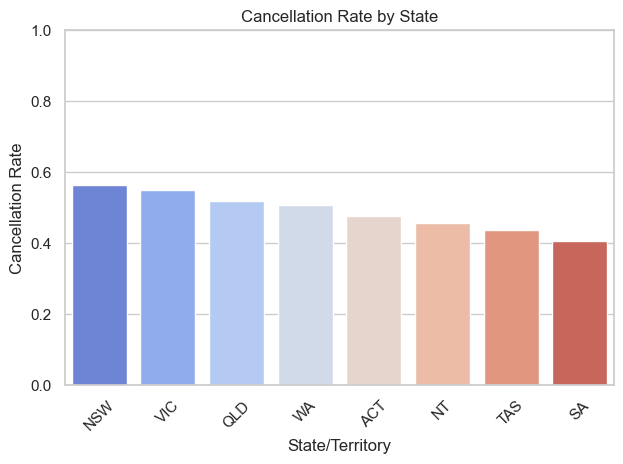

In [22]:
#plot results
# Reset index for plotting
state_plot = state_summary.reset_index()

sns.barplot(data=state_plot, x='state', y='cancel_rate', palette='coolwarm')
plt.title('Cancellation Rate by State')
plt.ylabel('Cancellation Rate')
plt.xlabel('State/Territory')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Key insights:
1. Larger states (NSW, VIC, QLD) have higher cancellation rates which suggest systematic challenges in managing apprenticeship support and training quality in areas with larger population
2. Smaller states have lower cancel rate which could be due to more manageable apprentice-to-support ratios and less occupational variety

# 3. Build ML model

I will build a machine learning model to better understand apprenticeship cancellation in Australia. The model will help identify key drivers of cancellation - such as occupation, gender, and location - and predict which apprentices are most at risk of cancelling. 

In [23]:
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [29]:
#Define features and target
categorical_features = ['occupation', 'gender', 'year', 'quarter', 'state']
X = df2_all[categorical_features]
y = df2_all['cancel']
weights = df2_all['count']  # Need pipeline to account for the count of each row value

In [30]:
#Preprocessing (OneHotEncoder for categorical variables)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'  # No numeric features to passthrough
)

In [31]:
# Create pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight=None))  # We'll use sample_weight instead
])

In [36]:
# Train-test split
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, stratify=y, random_state=42
)

# Fit model with weights
model.fit(X_train, y_train, classifier__sample_weight=weights_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['occupation', 'gender',
                                                   'year', 'quarter',
                                                   'state'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

              precision    recall  f1-score   support

           0       0.68      0.93      0.79      3776
           1       0.53      0.16      0.25      1941

    accuracy                           0.67      5717
   macro avg       0.60      0.54      0.52      5717
weighted avg       0.63      0.67      0.60      5717

ROC AUC: 0.6158241891083576


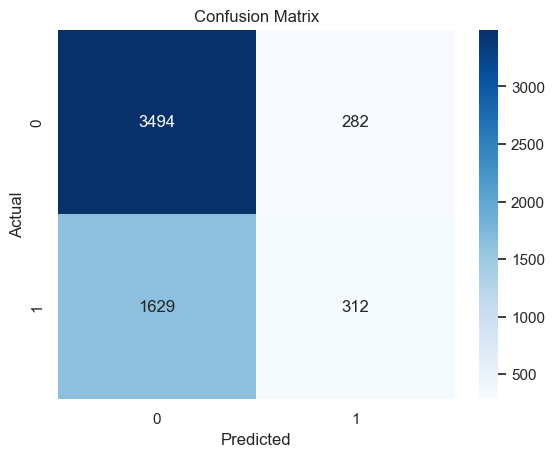

In [33]:
# Evaluate model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Summary of ML model:

We trained the logistic regression model to predict the likelihood of an apprentice cancelling their training contract based on the available features.
The model performs well in predicting completions (68% precision) however struggles to identify cancellations (53% precision).
ROC AUC score is 0.62 suggesting model has limited ability to distinguish between apprentice who cancel and those who complete. This may be due to insufficient predictive features.

# Conclusion

EDA Findings

Gender: Males had slightly higher cancellation rate (54%) compared to females (49%)
State: NSW and VIC had the highest cancellation rates (~55-56%), while SA had the lowest (41%)
Occupation: Roles in the hospitality sector had notably high cancellation rates

ML Model

The model struggled to identify cancelled apprenticeships (many false negatives). Suggest re testing with different model or using other predictive features.